<h1>Seminar 1: Optimizing Conference Paper </h1>
Assignment Using Genetic Algorithms <div>
Intelligent Systems <div>
October 28,

In [147]:
import numpy as np
%pip install pygad
import pygad
import random
import json
import itertools
import matplotlib.pyplot as plt
import os


Note: you may need to restart the kernel to use updated packages.


Data

KeyError: 'num_papers'

In [151]:
class Dataset:
    def __init__(self, data):
        self.num_papers = data.get('num_papers', None)
        self.num_reviewers = data.get('num_reviewers', None)
        self.reviewer_capacity = data.get('reviewer_capacity', None)
        self.min_reviews_per_paper = data.get('min_reviews_per_paper', None)
        self.max_reviews_per_paper = data.get('max_reviews_per_paper', None)
        self.num_generations = 100
        self.population_size = 50
        self.num_parents_mating = 20 
        self.P = np.array(data.get('preferences', None))
        self.F = np.array(data.get('friendships', None))
        self.A = np.array(data.get('authorship', None))
        self.initial_pop = self.make_initial_population()
        self.fitness_penalty = fitnes_penalty = {
                "friends": 2,
                "authorship": 8,
                "min_reviews": 5,
                "max_reviews":20,
                "reviewer_capacity": 9
            }
        self.fitness_function = self.create_fitness_function_basic()

        
    def make_initial_population(self):
        population = np.random.randint(0, 2, size=(self.population_size,self.num_reviewers * self.num_papers))
        return population
    def change_population_size(self, population_size):
        self.population_size = population_size
    def change_num_generations(self, num_generations):
        self.num_generations = num_generations
    def change_num_parents_mating(self, num_parents_mating):
        self.num_parents_mating = num_parents_mating
    def change_fitnes_penalty(self, name, value):
        self.fitnes_penalty[name] = value
    def create_fitness_function_basic(self):
        def fitness_func_basic(ga_instance, solution, solution_idx):
            preference_score = np.sum(solution * self.P.flatten())
            penalty = 0
            penalty += np.sum(solution * self.A.flatten()) * self.fitness_penalty["authorship"]
            reshaped_sol = solution.reshape((self.num_reviewers, self.num_papers))
            per_reviewer = np.sum(reshaped_sol, axis=1)
            per_paper = np.sum(reshaped_sol, axis=0)
            penalty += np.sum(per_paper < self.min_reviews_per_paper) * self.fitness_penalty["min_reviews"]
            penalty += np.sum(per_paper > self.max_reviews_per_paper) * self.fitness_penalty["max_reviews"]
            penalty += np.sum(per_reviewer > self.reviewer_capacity) * self.fitness_penalty["reviewer_capacity"]
            co_review_matrix = np.dot(reshaped_sol, reshaped_sol.T)
            friend_review_counts = self.F * co_review_matrix
            penalty += np.sum(friend_review_counts) // 2 * self.fitness_penalty["friends"]

            return preference_score - penalty
        return fitness_func_basic


In [152]:

# Path to the datasets folder
datasets_folder = 'datasets'

# List all files in the datasets folder
files = os.listdir(datasets_folder)

# Load each JSON file into the data dictionary
data = {}
for file_name in files:
    if file_name.endswith('.json'):
        file_path = os.path.join(datasets_folder, file_name)
        with open(file_path, 'r') as file:
            file_data = json.load(file)
    data[file_name] = Dataset(file_data)
print(data.keys())

for item in data.items():
    print(item[0])
    print(item[1].num_papers)
    print(item[1].num_reviewers)

    print("P",item[1].P.shape)
    print("F",item[1].F.shape)
    print("A",item[1].A.shape)
    print("population",item[1].initial_pop.shape)

dict_keys(['easy_dataset_1.json', 'easy_dataset_2.json', 'hard_dataset_1.json', 'hard_dataset_2.json', 'hard_dataset_3.json', 'hard_dataset_4.json', 'medium_dataset_1.json', 'medium_dataset_2.json'])
easy_dataset_1.json
5
5
P (5, 5)
F (5, 5)
A (5, 5)
population (50, 25)
easy_dataset_2.json
6
8
P (8, 6)
F (8, 8)
A (8, 6)
population (50, 48)
hard_dataset_1.json
15
10
P (10, 15)
F (10, 10)
A (10, 15)
population (50, 150)
hard_dataset_2.json
20
12
P (12, 20)
F (12, 12)
A (12, 20)
population (50, 240)
hard_dataset_3.json
25
15
P (15, 25)
F (15, 15)
A (15, 25)
population (50, 375)
hard_dataset_4.json
30
18
P (18, 30)
F (18, 18)
A (18, 30)
population (50, 540)
medium_dataset_1.json
10
7
P (7, 10)
F (7, 7)
A (7, 10)
population (50, 70)
medium_dataset_2.json
12
8
P (8, 12)
F (8, 8)
A (8, 12)
population (50, 96)


<h2>Changing the parameters of genetic algorithm </h2>

In [ ]:
import pygad
import numpy as np
import matplotlib.pyplot as plt

def run_ga_and_plot_fitness(dataset_name, param_name, param_values, fitnes_penalty, initial_pop, num_generations, num_parents_mating, population_size, fitness_function, num_reviewers, num_papers):
    fitness_history = {str(value): [] for value in param_values}
    
    for value in param_values:
        ga_params = {
            'num_generations': num_generations,
            'num_parents_mating': num_parents_mating,
            'fitness_func': fitness_function,
            'sol_per_pop': population_size,
            'num_genes': num_reviewers * num_papers,
            'initial_population': initial_pop,
            'crossover_type': "single_point",
            'mutation_probability': 0.05,
            'gene_type': int,
            'gene_space': [0, 1],
            'stop_criteria': "saturate_50",
            'parent_selection_type': "tournament"
        }
        
        if param_name == 'mutation_type':
            ga_params['mutation_type'] = value
        elif param_name == 'mutation_probability':
            ga_params['mutation_probability'] = value
        elif param_name == 'crossover_type':
            ga_params['crossover_type'] = value
        elif param_name == 'parent_selection_type':
            ga_params['parent_selection_type'] = value
        elif param_name == 'num_parents_mating':
            ga_params['num_parents_mating'] = value
        ga_instance = pygad.GA(**ga_params)
        
        ga_instance.run()
        fitness_history[str(value)] = ga_instance.best_solutions_fitness
    
    return fitness_history

# Example usage
num_generations = 100
population_size = 50
num_parents_mating = 10
num_reviewers = 5
num_papers = 5

# Assuming other variables like P, F, A, fitnes_penalty, initial_pop are already defined

mutation_funcs = ["random", "swap", "inversion", "scramble"]
mutation_names = ["Random", "Swap", "Inversion", "Scramble"]

mutation_rates = [0.05, 0.1, 0.15, 0.2,0.25]
crossover_types = ["single_point", "uniform"]

parent_selection_types = ["sss", "rws", "sus","rank","random","tournament"]	
num_parents_mating = [10, 20, 30, 40, 50]
# Create subplots
num_datasets = len(data)
fig, axes = plt.subplots(2, 4, figsize=(20, 10))
plt.subplots_adjust(top=1)
for i, (key, dataset) in enumerate(data.items()):
    print(key)
    fitness_function = dataset.fitness_function
    
    # Plot for different mutation types
    #fitness_history = run_ga_and_plot_fitness(key, 'mutation_type', mutation_funcs, dataset.fitness_penalty, dataset.initial_pop, dataset.num_generations, dataset.num_parents_mating, dataset.population_size, fitness_function, dataset.num_reviewers, dataset.num_papers)
    for name in mutation_funcs:
        fitness_history = run_ga_and_plot_fitness(key, 'mutation_type', mutation_funcs, dataset.fitness_penalty, dataset.initial_pop, dataset.num_generations, dataset.num_parents_mating, dataset.population_size, fitness_function, dataset.num_reviewers, dataset.num_papers)
        axes[i // 4, i % 4].plot(fitness_history[str(name)], label=f"Mutation Type: {name}")
    
    axes[i // 4, i % 4].set_xlabel("Generation")
    axes[i // 4, i % 4].set_ylabel("Fitness")
   # axes[i // 4, i % 4].set_title(f"Fitness over Generations for Different Parameters ({key})")

# Create a single legend for all subplots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(mutation_funcs))

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
plt.subplots_adjust(top=1)

for i, (key, dataset) in enumerate(data.items()):
    #print(key)
    fitness_function = dataset.fitness_function
    
    # Plot for different mutation types
   
    for name in mutation_rates:
        fitness_history = run_ga_and_plot_fitness(key, 'mutation_probability', mutation_rates, dataset.fitness_penalty, dataset.initial_pop, dataset.num_generations, dataset.num_parents_mating, dataset.population_size, fitness_function, dataset.num_reviewers, dataset.num_papers)
        axes[i // 4, i % 4].plot(fitness_history[str(name)], label=f"Mutation rate: {name}")
    
    axes[i // 4, i % 4].set_xlabel("Generation")
    axes[i // 4, i % 4].set_ylabel("Fitness")
   # axes[i // 4, i % 4].set_title(f"Fitness over Generations for Different Parameters ({key})")

# Create a single legend for all subplots
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(mutation_rates))

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
plt.subplots_adjust(top=1)
for ctype in crossover_types:
        fitness_history = run_ga_and_plot_fitness(key, 'crossover_type', crossover_types, dataset.fitness_penalty, dataset.initial_pop, dataset.num_generations, dataset.num_parents_mating, dataset.population_size, fitness_function, dataset.num_reviewers, dataset.num_papers)
        axes[i // 4, i % 4].plot(fitness_history[ctype], label=f"Crossover Type: {ctype}")
        axes[i // 4, i % 4].set_xlabel("Generation")
        axes[i // 4, i % 4].set_ylabel("Fitness")

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(crossover_types))

plt.tight_layout()
plt.show()

fig, axes = plt.subplots(2, 4, figsize=(20, 10))
plt.subplots_adjust(top=1)
for ctype in parent_selection_types:
        fitness_history = run_ga_and_plot_fitness(key, 'parent_selection_type',parent_selection_types , dataset.fitness_penalty, dataset.initial_pop, dataset.num_generations, dataset.num_parents_mating, dataset.population_size, fitness_function, dataset.num_reviewers, dataset.num_papers)
        axes[i // 4, i % 4].plot(fitness_history[ctype], label=f"Crossover Type: {ctype}")
        axes[i // 4, i % 4].set_xlabel("Generation")
        axes[i // 4, i % 4].set_ylabel("Fitness")

handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(parent_selection_types))

plt.tight_layout()
plt.show()


fig, axes = plt.subplots(2, 4, figsize=(20, 10))
plt.subplots_adjust(top=1)
for ctype in num_parents_mating:
        fitness_history = run_ga_and_plot_fitness(key, 'num_parents_mating',num_parents_mating , dataset.fitness_penalty, dataset.initial_pop, dataset.num_generations, dataset.num_parents_mating, dataset.population_size, fitness_function, dataset.num_reviewers, dataset.num_papers)
        axes[i // 4, i % 4].plot(fitness_history[ctype], label=f"Crossover Type: {ctype}")
        axes[i // 4, i % 4].set_xlabel("Generation")
        axes[i // 4, i % 4].set_ylabel("Fitness")
handles, labels = axes[0, 0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper center', ncol=len(num_parents_mating))
plt.tight_layout()
plt.show()

easy_dataset_1.json
easy_dataset_2.json
hard_dataset_1.json


<h3> Print functions </h3>

In [7]:

def print_solution(solution_matrix):
    solution_matrix = solution_matrix.reshape((num_reviewers, num_papers))

    header = "Reviewers\\Papers||| " + " | ".join([f"Paper {i+1}" for i in range(num_papers)])
    print(header)
    print("-" * len(header))

    # Print each reviewer's assignments
    for reviewer_idx in range(num_reviewers):
        row = f"Reviewer {reviewer_idx+1:<6} |||   " + "  |   ".join(f"{value:<4}" for value in solution_matrix[reviewer_idx])
        print(row)


<h2>Task 1 - Representation <h2>
<h3>
 -   Deciding on an effective solution representation. <div>
 -   Designing a fitness function. <div>
 -   Implementing and executing the genetic algorithm. <div>

In [64]:
def solution_is_valid(solution,A,F,get_sum=True,print_values=False, return_matrix = False):
    solution = solution.flatten()
    penalty_authorship = 0
    penalty_min_reviews = 0
    penalty_max_reviews = 0
    penalty_reviewer_capacity = 0
    penalty_friends = 0
    penalty_authorship = np.sum(solution * A.flatten())
    reshaped_sol = solution.reshape((num_reviewers, num_papers))
    per_reviewer = np.sum(reshaped_sol, axis=1)
    per_paper = np.sum(reshaped_sol, axis=0)
    penalty_min_reviews = np.sum(per_paper < min_reviews_per_paper)
    penalty_max_reviews = np.sum(per_paper > max_reviews_per_paper)
    penalty_reviewer_capacity = np.sum(per_reviewer > reviewer_capacity)
    co_review_matrix = np.dot(reshaped_sol, reshaped_sol.T)
    friend_review_counts = F * co_review_matrix
    penalty_friends = np.sum(friend_review_counts) // 2
    authored_papers_by_friends = np.dot(F, A)
    penalty_matrix = reshaped_sol * authored_papers_by_friends
   # penalty_friends += np.sum(penalty_matrix)

    if print_values:
        print("penalty_authorship: ", penalty_authorship)
        print("penalty_min_reviews: ", penalty_min_reviews)
        print("penalty_max_reviews: ", penalty_max_reviews)
        print("penalty_reviewer_capacity: ", penalty_reviewer_capacity)
        print("penalty_friends: ", penalty_friends)
        print("Sum: ", penalty_authorship + penalty_min_reviews + penalty_max_reviews + penalty_reviewer_capacity + penalty_friends)

    if return_matrix:
        sol = (penalty_authorship, penalty_min_reviews, penalty_max_reviews, penalty_reviewer_capacity, penalty_friends)
        return np.array(sol)
    if (not get_sum):
        return (penalty_authorship, penalty_min_reviews, penalty_max_reviews, penalty_reviewer_capacity, penalty_friends)
    else:
        return (penalty_authorship + penalty_min_reviews + penalty_max_reviews + penalty_reviewer_capacity + penalty_friends)
  
def initial_population(num_reviewers, num_papers, population_size,num=5):
    best_population = None
    best_count = None
    first = True
    for i in range(num):
        population = np.random.randint(0, 2, size=(population_size, num_reviewers * num_papers))
        count = 0
        for j in range(population_size):
            count += solution_is_valid(population[j], get_sum=True,print_values=False)
        count /= population_size
        if first or count > best_count:
            first = False
            best_count = count
            best_population = population

    print("Best count: ", best_count)
    return population
def create_fitness_function_basic(fitness_penalty):
    def fitness_func_basic(ga_instance, solution, solution_idx):
        preference_score = np.sum(solution * P.flatten())
        penalty = 0
        penalty += np.sum(solution * A.flatten()) * fitness_penalty["authorship"]
        reshaped_sol = solution.reshape((num_reviewers, num_papers))
        per_reviewer = np.sum(reshaped_sol, axis=1)
        per_paper = np.sum(reshaped_sol, axis=0)
        penalty += np.sum(per_paper < min_reviews_per_paper) * fitness_penalty["min_reviews"]
        penalty += np.sum(per_paper > max_reviews_per_paper) * fitness_penalty["max_reviews"]
        penalty += np.sum(per_reviewer > reviewer_capacity) * fitness_penalty["reviewer_capacity"]
        co_review_matrix = np.dot(reshaped_sol, reshaped_sol.T)
        friend_review_counts = F * co_review_matrix
        penalty += np.sum(friend_review_counts) // 2 * fitness_penalty["friends"]

        return preference_score - penalty
    return fitness_func_basic

In [9]:
fitnes_penalty = {
    "friends": 2,
    "authorship": 8,
    "min_reviews": 12,
    "max_reviews": 12,
    "reviewer_capacity": 9
}
initial_pop = initial_population(num_reviewers, num_papers, population_size)

ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=num_parents_mating,
    fitness_func=create_fitness_function_basic(fitnes_penalty),
    sol_per_pop=population_size,
    num_genes=num_reviewers * num_papers,
    initial_population=initial_pop,
    crossover_type="single_point",
    mutation_type="random",
    mutation_percent_genes=5,
    gene_type=int,
    gene_space=[0, 1],
    stop_criteria= "saturate_50",
    parent_selection_type="rank",
)


Best count:  7.82


c:\Users\Vid\miniconda3\envs\ls_a01\Lib\site-packages\pygad\pygad.py:1139: UserWarning: The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.
  warnings.warn("The 'delay_after_gen' parameter is deprecated starting from PyGAD 3.3.0. To delay or pause the evolution after each generation, assign a callback function/method to the 'on_generation' parameter to adds some time delay.")


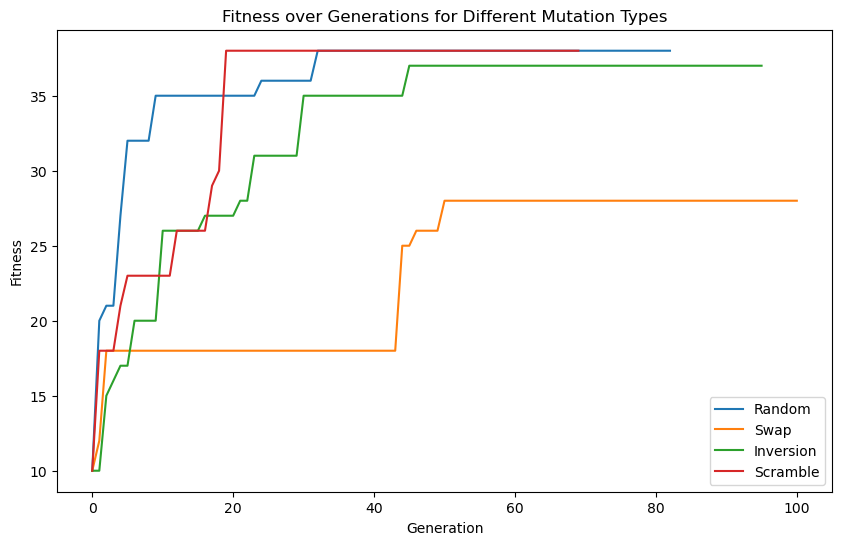

In [10]:
def run_ga_and_plot_fitness(mutation_funcs, mutation_names):
    fitness_history = {name: [] for name in mutation_names}
    
    for mutation_func, name in zip(mutation_funcs, mutation_names):
        ga_instance = pygad.GA(
            num_generations=num_generations,
            num_parents_mating=num_parents_mating,
            fitness_func=create_fitness_function_basic(fitnes_penalty),
            sol_per_pop=population_size,
            num_genes=num_reviewers * num_papers,
            initial_population=initial_pop,
            crossover_type="single_point",
            mutation_type=mutation_func,
            mutation_probability=0.05,
            gene_type=int,
            gene_space=[0, 1],
            stop_criteria="saturate_50",
            parent_selection_type="tournament"
        )
        
        ga_instance.run()
        fitness_history[name] = ga_instance.best_solutions_fitness
        
    # Plot the fitness history
    plt.figure(figsize=(10, 6))
    for name in mutation_names:
        plt.plot(fitness_history[name], label=name)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness over Generations for Different Mutation Types")
    plt.legend()
    plt.show()


mutation_funcs = ["random", "swap", "inversion","scramble"]	
mutation_names = ["Random", "Swap", "Inversion", "Scramble"]

run_ga_and_plot_fitness(mutation_funcs, mutation_names)

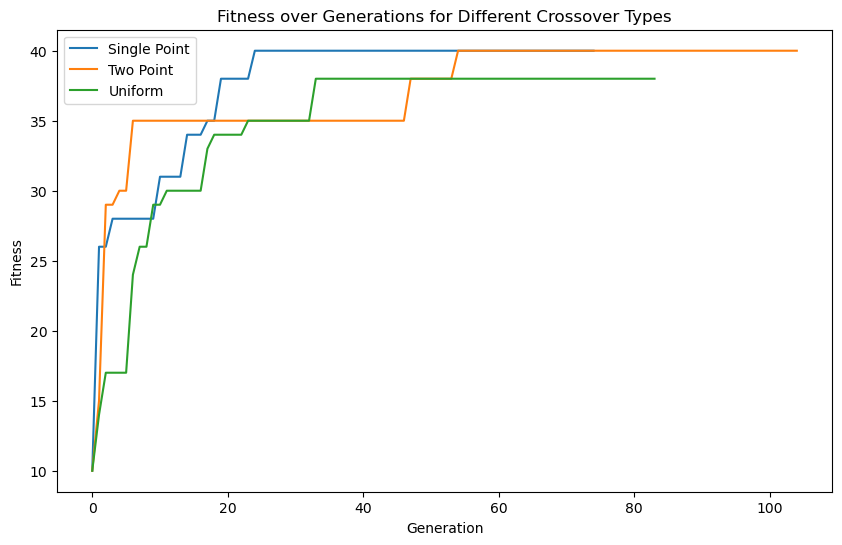

In [11]:
def run_ga_and_plot_fitness(crossover_functions, crossover_names):
    fitness_history = {name: [] for name in crossover_names}
    
    for crossover_func, name in zip(crossover_functions, crossover_names):
        ga_instance = pygad.GA(
            num_generations=num_generations,
            num_parents_mating=num_parents_mating,
            fitness_func=create_fitness_function_basic(fitnes_penalty),
            sol_per_pop=population_size,
            num_genes=num_reviewers * num_papers,
            initial_population=initial_pop,
            crossover_type=crossover_func,
            mutation_type="random",
            mutation_probability=0.05,
            gene_type=int,
            gene_space=[0, 1],
            stop_criteria="saturate_50",
            parent_selection_type="tournament"
        )
        
        ga_instance.run()
        fitness_history[name] = ga_instance.best_solutions_fitness
        
    # Plot the fitness history
    plt.figure(figsize=(10, 6))
    for name in mutation_names:
        plt.plot(fitness_history[name], label=name)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness over Generations for Different Crossover Types")
    plt.legend()
    plt.show()


mutation_funcs = ["single_point", "two_points", "uniform"]	
mutation_names = ["Single Point", "Two Point", "Uniform"]

run_ga_and_plot_fitness(mutation_funcs, mutation_names)

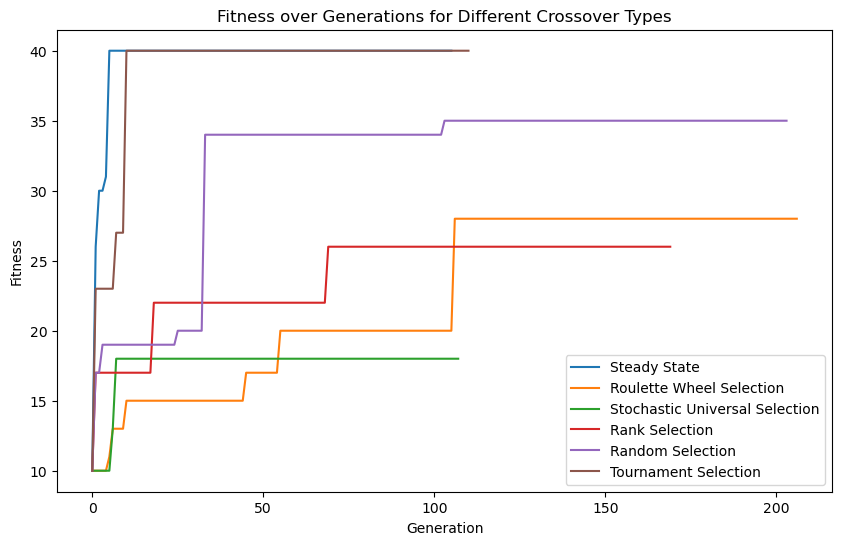

In [22]:

def run_ga_and_plot_fitness(parents_selection, parents_selection_names):
    fitness_history = {name: [] for name in parents_selection_names}
    
    for crossover_func, name in zip(parents_selection, parents_selection_names):
        ga_instance = pygad.GA(
            num_generations=num_generations,
            num_parents_mating=num_parents_mating,
            fitness_func=create_fitness_function_basic(fitnes_penalty),
            sol_per_pop=population_size,
            num_genes=num_reviewers * num_papers,
            initial_population=initial_pop,
            crossover_type="single_point",
            mutation_type="random",
            mutation_probability=0.2,
            gene_type=int,
            gene_space=[0, 1],
            stop_criteria="saturate_100",
            parent_selection_type=crossover_func
        )
        
        ga_instance.run()
        fitness_history[name] = ga_instance.best_solutions_fitness
        
    # Plot the fitness history
    plt.figure(figsize=(10, 6))
    for name in mutation_names:
        plt.plot(fitness_history[name], label=name)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness over Generations for Different Crossover Types")
    plt.legend()
    plt.show()


mutation_funcs = ["sss", "rws", "sus","rank","random","tournament"]	
mutation_names = ["Steady State", "Roulette Wheel Selection", "Stochastic Universal Selection", "Rank Selection", "Random Selection", "Tournament Selection"]
    
run_ga_and_plot_fitness(mutation_funcs, mutation_names)

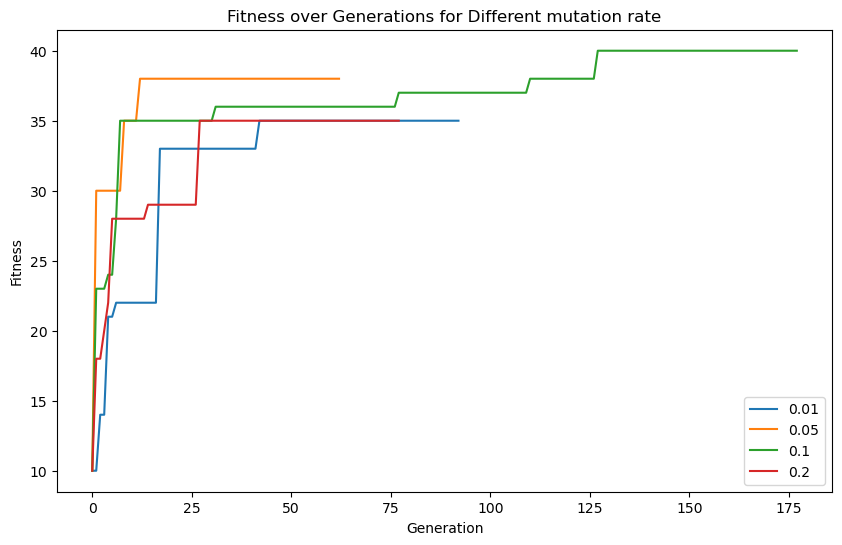

In [20]:
def run_ga_and_plot_fitness(crossover_functions, crossover_names):
    fitness_history = {name: [] for name in crossover_names}
    
    for crossover_func, name in zip(crossover_functions, crossover_names):
        ga_instance = pygad.GA(
            num_generations=num_generations,
            num_parents_mating=num_parents_mating,
            fitness_func=create_fitness_function_basic(fitnes_penalty),
            sol_per_pop=population_size,
            num_genes=num_reviewers * num_papers,
            initial_population=initial_pop,
            crossover_type="single_point",
            mutation_type="random",
            mutation_probability=crossover_func,
            gene_type=int,
            gene_space=[0, 1],
            stop_criteria="saturate_50",
            parent_selection_type="tournament"
        )
        
        ga_instance.run()
        fitness_history[name] = ga_instance.best_solutions_fitness
        
    # Plot the fitness history
    plt.figure(figsize=(10, 6))
    for name in mutation_names:
        plt.plot(fitness_history[name], label=name)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness over Generations for Different mutation rate")
    plt.legend()
    plt.show()


mutation_funcs = [0.01,0.05,0.1,0.2]	
mutation_names = ["0.01", "0.05", "0.1", "0.2"]

run_ga_and_plot_fitness(mutation_funcs, mutation_names)

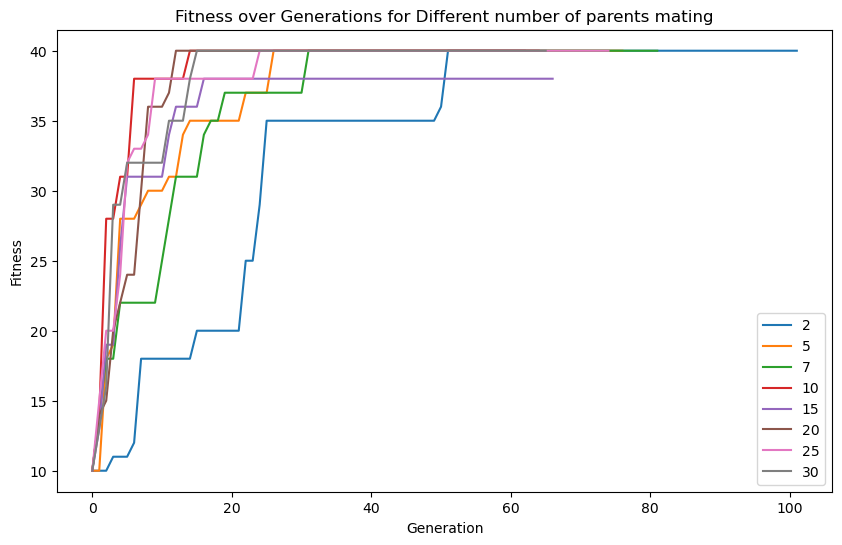

In [49]:
def run_ga_and_plot_fitness(crossover_functions, crossover_names):
    fitness_history = {name: [] for name in crossover_names}
    
    for crossover_func, name in zip(crossover_functions, crossover_names):
        ga_instance = pygad.GA(
            num_generations=num_generations,
            num_parents_mating=crossover_func,
            fitness_func=create_fitness_function_basic(fitnes_penalty),
            sol_per_pop=population_size,
            num_genes=num_reviewers * num_papers,
            initial_population=initial_pop,
            crossover_type="single_point",
            mutation_type="random",
            mutation_probability=0.05,
            gene_type=int,
            gene_space=[0, 1],
            stop_criteria="saturate_50",
            parent_selection_type="tournament"
        )
        
        ga_instance.run()
        fitness_history[name] = ga_instance.best_solutions_fitness
        
    # Plot the fitness history
    plt.figure(figsize=(10, 6))
    for name in mutation_names:
        plt.plot(fitness_history[name], label=name)
    plt.xlabel("Generation")
    plt.ylabel("Fitness")
    plt.title("Fitness over Generations for Different number of parents mating")
    plt.legend()
    plt.show()


mutation_funcs = [2,5,7,10,15,20,25,30]
mutation_names = ["2", "5", "7", "10", "15", "20","25","30"]

run_ga_and_plot_fitness(mutation_funcs, mutation_names)

#### After evaluation we have concluded that the best parameters for the normal genetic algorithm are:
- Number of parents mating: 15, 20
- Mutation rate: 0.05, 0.1
- Parent selection type: tournament, Steady State
- Crossover type: uniform, single_point
- Mutation type: random, Scramble

This will set a starting point for our development of custom mutation and crossover functions

<h2> Task 2 - Crossover and Mutation (30%) </h2>
<h3> 
- Modify the crossover and mutation functions to ensure the generation of valid assignments. <div>
- Consider the structure and constraints of the assignment problem during mutation and crossover. <div>
- Utilize existing genetic algorithm libraries, such as PyGAD, and
adapt them to suit this problem. <div>


<h3> function to check valid solution:


In [ ]:

def solution_is_valid(solution,get_sum=True,print_values=False,return_coorect=False, return_matrix=False):
    solution = solution.flatten()
    penalty_authorship = 0
    penalty_min_reviews = 0
    penalty_max_reviews = 0
    penalty_reviewer_capacity = 0
    penalty_friends = 0
    penalty_authorship = np.sum(solution * A.flatten())
    reshaped_sol = solution.reshape((num_reviewers, num_papers))
    per_reviewer = np.sum(reshaped_sol, axis=1)
    per_paper = np.sum(reshaped_sol, axis=0)
    penalty_min_reviews = np.sum(per_paper < min_reviews_per_paper)
    penalty_max_reviews = np.sum(per_paper > max_reviews_per_paper)
    penalty_reviewer_capacity = np.sum(per_reviewer > reviewer_capacity)
    co_review_matrix = np.dot(reshaped_sol, reshaped_sol.T)
    friend_review_counts = F * co_review_matrix
    penalty_friends = np.sum(friend_review_counts) // 2
    authored_papers_by_friends = np.dot(F, A)
    penalty_matrix = reshaped_sol * authored_papers_by_friends
   # penalty_friends += np.sum(penalty_matrix)

    if print_values:
        print("penalty_authorship: ", penalty_authorship)
        print("penalty_min_reviews: ", penalty_min_reviews)
        print("penalty_max_reviews: ", penalty_max_reviews)
        print("penalty_reviewer_capacity: ", penalty_reviewer_capacity)
        print("penalty_friends: ", penalty_friends)
        print("Sum: ", penalty_authorship + penalty_min_reviews + penalty_max_reviews + penalty_reviewer_capacity + penalty_friends)
    if return_coorect:
        vector = np.array([penalty_authorship, penalty_min_reviews, penalty_max_reviews, penalty_reviewer_capacity, penalty_friends])
        return np.where(vector > 1, 1, 0)
    if return_matrix:
        sol = (penalty_authorship, penalty_min_reviews, penalty_max_reviews, penalty_reviewer_capacity, penalty_friends)
        return np.array(sol)
    if (not get_sum):
        return (penalty_authorship, penalty_min_reviews, penalty_max_reviews, penalty_reviewer_capacity, penalty_friends)
    else:
        return (penalty_authorship + penalty_min_reviews + penalty_max_reviews + penalty_reviewer_capacity + penalty_friends)
    


In [23]:
def custom__single_point_mutation(offspring, ga_instance):
    number_tries = 10
    #we do one mutation 
    for idx in range(offspring.shape[0]):
        initial_vector_constrains = solution_is_valid(offspring[idx], get_sum=False, print_values=False, return_matrix=True)
        constraint_vector = np.array([1 if val == 0 else 0 for val in initial_vector_constrains])
        
        number_mutations = offspring.shape[1] 
        number_tries = 10
        while number_tries > 0:
            gene_idx = np.random.randint(0, offspring.shape[1])
            offspring[idx, gene_idx] = 1 - offspring[idx, gene_idx]
            
            new_constraint_vector = solution_is_valid(offspring[idx], get_sum=False, print_values=False, return_matrix=True)
            if np.all(new_constraint_vector[constraint_vector == 1] == 0):
                number_tries -= 1
            else:
                # If not, revert the mutation
                offspring[idx, gene_idx] = 1 - offspring[idx, gene_idx]
                number_tries -= 1
    if(number_tries != 0):
        print("Mutation failed",number_mutations," times",number_tries)
    return offspring


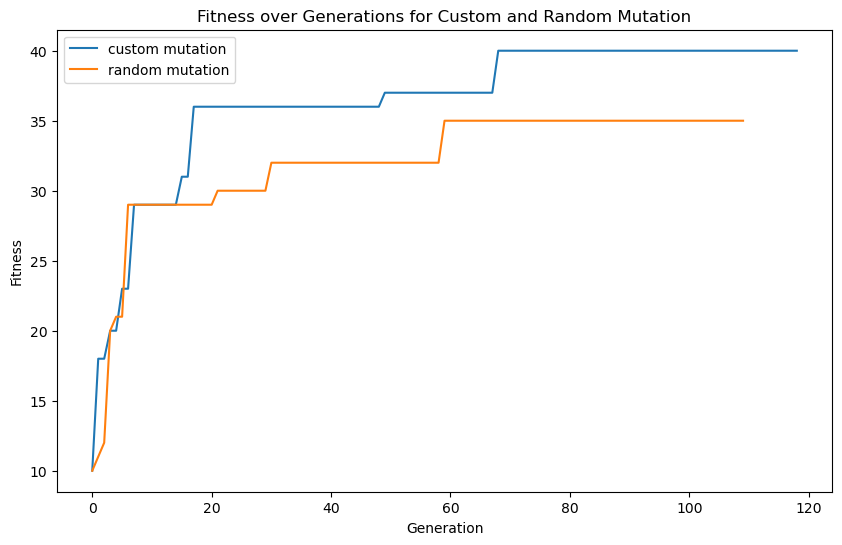

In [30]:


ga_instance_c= pygad.GA(
    num_generations=num_generations,
    num_parents_mating=20,
    fitness_func=create_fitness_function_basic(fitnes_penalty),
    sol_per_pop=population_size,
    num_genes=num_reviewers * num_papers,
    initial_population=initial_pop,
    crossover_type="single_point",
    mutation_type=custom__single_point_mutation,
    mutation_probability=0.20,
    gene_type=int,
    gene_space=[0, 1],
    stop_criteria="saturate_50",
    parent_selection_type="tournament"
)
ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=20,
    fitness_func=create_fitness_function_basic(fitnes_penalty),
    sol_per_pop=population_size,
    num_genes=num_reviewers * num_papers,
    initial_population=initial_pop,
    crossover_type="single_point",
    mutation_type="random",
    mutation_probability=0.20,
    gene_type=int,
    gene_space=[0, 1],
    stop_criteria="saturate_50",
    parent_selection_type="tournament"
)

ga_instance_c.run()
ga_instance.run()

# Collect fitness history
fitness_history = {}
fitness_history[0] = ga_instance_c.best_solutions_fitness
fitness_history[1] = ga_instance.best_solutions_fitness

# Plot the fitness history
plt.figure(figsize=(10, 6))
for i in range(2):
    plt.plot(fitness_history[i], label="custom mutation" if i == 0 else "random mutation")

plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations for Custom and Random Mutation")
plt.legend()
plt.show()

In [ ]:
def custom_crossover_funct(parents, offspring_size, ga_instance):
    #print(offspring_size)
    offspring = []
    idx = 0
    #print(parents.shape)
    while len(offspring) != offspring_size[0]:
        number_tries = 5
        
        parent1 = parents[idx % parents.shape[0], :].copy()
        parent2 = parents[(idx + 1) % parents.shape[0], :].copy()
        vect_1 = solution_is_valid(parent1, get_sum=False, print_values=False, return_matrix=True)
        vect_2 = solution_is_valid(parent2, get_sum=False, print_values=False, return_matrix=True)
        best = vect_1
        if np.sum(vect_1) > np.sum(vect_2):
            best = vect_2 
        while(number_tries > 0):
            random_split_point = np.random.choice(range(offspring_size[1]))
            new_offspring = parent1.copy()
            new_offspring[random_split_point:] = parent2[random_split_point:]
            new_constraint_vector = solution_is_valid(new_offspring, get_sum=False, print_values=False, return_matrix=True)
            constraint_vector = np.array([1 if val == 0 else 0 for val in best])
            if np.all(new_constraint_vector[constraint_vector == 1] == 0):
                offspring.append(new_offspring)
                number_tries = 0
                #print("Crossover success")
            number_tries -= 1
            if number_tries == 0:
                #print("Crossover failed")
                offspring.append(new_offspring)
        idx += 1

    return np.array(offspring)
    

penalty_authorship:  0
penalty_min_reviews:  1
penalty_max_reviews:  0
penalty_reviewer_capacity:  0
penalty_friends:  1
Sum:  2
penalty_authorship:  0
penalty_min_reviews:  0
penalty_max_reviews:  0
penalty_reviewer_capacity:  1
penalty_friends:  1
Sum:  2


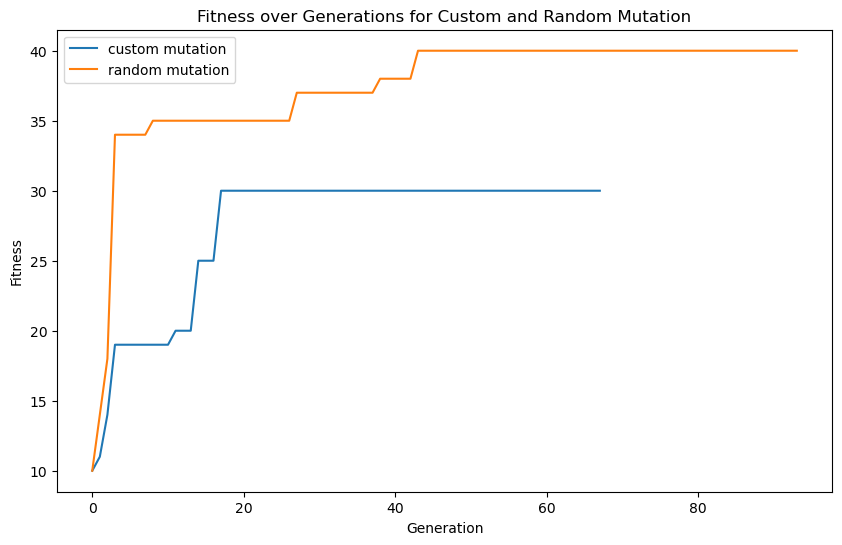

In [51]:


ga_instance_c= pygad.GA(
    num_generations=num_generations,
    num_parents_mating=20,
    fitness_func=create_fitness_function_basic(fitnes_penalty),
    sol_per_pop=population_size,
    num_genes=num_reviewers * num_papers,
    initial_population=initial_pop,
    crossover_type=custom_crossover_funct,
    mutation_type=custom__single_point_mutation,
    mutation_probability=0.20,
    gene_type=int,
    gene_space=[0, 1],
    stop_criteria="saturate_50",
    parent_selection_type="tournament"
)
ga_instance = pygad.GA(
    num_generations=num_generations,
    num_parents_mating=20,
    fitness_func=create_fitness_function_basic(fitnes_penalty),
    sol_per_pop=population_size,
    num_genes=num_reviewers * num_papers,
    initial_population=initial_pop,
    crossover_type="single_point",
    mutation_type=custom__single_point_mutation,
    mutation_probability=0.20,
    gene_type=int,
    gene_space=[0, 1],
    stop_criteria="saturate_50",
    parent_selection_type="tournament"
)

ga_instance_c.run()
ga_instance.run()

# Collect fitness history
fitness_history = {}
fitness_history[0] = ga_instance_c.best_solutions_fitness
fitness_history[1] = ga_instance.best_solutions_fitness
solution, solution_fitness, solution_idx = ga_instance_c.best_solution()
solution_is_valid(solution, get_sum=False, print_values=True)
solution, solution_fitness, solution_idx = ga_instance.best_solution()
solution_is_valid(solution, get_sum=False, print_values=True)
# Plot the fitness history
plt.figure(figsize=(10, 6))
for i in range(2):
    plt.plot(fitness_history[i], label="custom mutation" if i == 0 else "random mutation")

plt.xlabel("Generation")
plt.ylabel("Fitness")
plt.title("Fitness over Generations for Custom and Random Mutation")
plt.legend()
plt.show()

<h2> Task 3 - Complexity and Diversity </h2>
